In [1]:
import pathpyG as pp
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import torch
from collections import defaultdict, deque
import numpy as np
import time

In [3]:
df = pd.read_csv('sx-askubuntu.txt', sep=" ", header=None)
df.columns = ['source', 'destination', 'timestamp']
df.head()

,source,destination,timestamp
0,4,5,1280369730
1,4,27,1280370413
2,10,27,1280370452
3,4,10,1280370641
4,41,43,1280370665


In [4]:
df.dropna(inplace=True)  # Drop rows with missing values

# Convert cleaned DataFrame to list of tuples (source, destination, timestamp)
data_tuples = list(df.itertuples(index=False, name=None))

In [5]:
print(len(df))

964437


In [6]:
# Step 1: Extract and sort timestamps
timestamps = df['timestamp'].sort_values().to_numpy()

# Step 2: Calculate time intervals
intervals = np.diff(timestamps)

# Step 3: Calculate average interval
average_interval = np.mean(intervals)

print(f"Average time interval: {average_interval} seconds")

Average time interval: 234.16220671978235 seconds


In [7]:
# Define the PaCo algorithm
def paco(data, delta, max_length):
    """
    Implements the PaCo algorithm for counting causal paths in temporal networks.
    
    Args:
    - data: List of tuples (source, destination, timestamp).
    - delta: Maximum time difference between consecutive links.
    - max_length: Maximum path length (K).
    
    Returns:
    - path_counts: Dictionary of causal paths and their counts.
    """
    # Sort data by timestamp
    data = sorted(data, key=lambda x: x[2])
    
    # Initialize sliding window and path counters
    window = deque()  # Sliding window
    path_counts = defaultdict(int)  # Overall causal path counts
    
    # Iterate through each link in the data
    for (s, d, t) in data:
        current_counts = defaultdict(int)  # Local counts for current link
        current_counts[(s, d)] = 1  # A single link is a causal path of length 1
        
        # Update the sliding window: remove outdated links
        while window and window[0][2] < t - delta:
            window.popleft()
        
        # Extend paths from the sliding window
        for (prev_s, prev_d, prev_t, prev_counts) in window:
            if prev_d == s and prev_t < t:  # Valid path extension
                for path, count in prev_counts.items():
                    if len(path) < max_length:  # Enforce maximum path length
                        extended_path = path + (d,)
                        current_counts[extended_path] += count
        
        # Update global counts
        for path, count in current_counts.items():
            path_counts[path] += count
        
        # Add current link and its paths to the sliding window
        window.append((s, d, t, current_counts))
    
    return path_counts


In [9]:
delta_values = [12000, 18000, 24000]
max_length_values = [2, 3, 4, 5, 6]

# Loop through the values and measure execution time
for delta in delta_values:
    for max_length in max_length_values:
        start_time = time.time()  # Record start time
        results = paco(data_tuples, delta, max_length)
        end_time = time.time()  # Record end time
        elapsed_time = end_time - start_time  # Calculate elapsed time
        
        print(f"Max Time Delta: {delta}, Max length: {max_length} -> Time Taken: {elapsed_time:.4f} seconds")

Max Time Delta: 12000, Max length: 2 -> Time Taken: 1.4757 seconds
Max Time Delta: 12000, Max length: 3 -> Time Taken: 1.8353 seconds
Max Time Delta: 12000, Max length: 4 -> Time Taken: 2.4852 seconds
Max Time Delta: 12000, Max length: 5 -> Time Taken: 2.9650 seconds
Max Time Delta: 12000, Max length: 6 -> Time Taken: 3.7699 seconds
Max Time Delta: 18000, Max length: 2 -> Time Taken: 1.8702 seconds
Max Time Delta: 18000, Max length: 3 -> Time Taken: 2.1744 seconds
Max Time Delta: 18000, Max length: 4 -> Time Taken: 2.6507 seconds
Max Time Delta: 18000, Max length: 5 -> Time Taken: 3.3990 seconds
Max Time Delta: 18000, Max length: 6 -> Time Taken: 4.3445 seconds
Max Time Delta: 24000, Max length: 2 -> Time Taken: 2.2863 seconds
Max Time Delta: 24000, Max length: 3 -> Time Taken: 2.5980 seconds
Max Time Delta: 24000, Max length: 4 -> Time Taken: 3.1818 seconds
Max Time Delta: 24000, Max length: 5 -> Time Taken: 4.0875 seconds
Max Time Delta: 24000, Max length: 6 -> Time Taken: 5.2660 sec

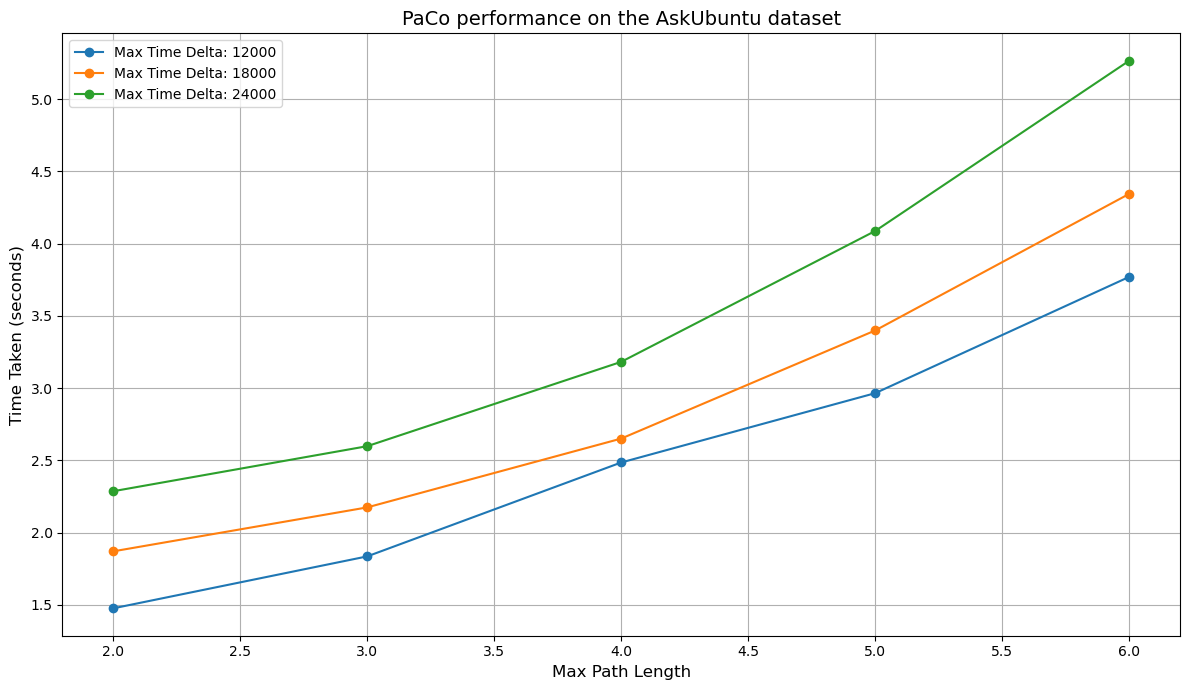

In [11]:
time_deltas = [12000, 18000, 24000]
max_lengths = [2, 3, 4, 5, 6]
times = {
    12000: [1.4757, 1.8353, 2.4852, 2.9650, 3.7699],
    18000: [1.8702, 2.1744, 2.6507, 3.3990, 4.3445],
    24000: [2.2863, 2.5980, 3.1818, 4.0875, 5.2660]
}

# Plotting
plt.figure(figsize=(12, 7))

# Loop through each Max Time Delta to create a line for it
for delta in time_deltas:
    plt.plot(max_lengths, times[delta], marker='o', label=f"Max Time Delta: {delta}")

# Labels and title
plt.xlabel("Max Path Length", fontsize=12)
plt.ylabel("Time Taken (seconds)", fontsize=12)
plt.title("PaCo performance on the AskUbuntu dataset", fontsize=14)
plt.legend()

# Grid and layout adjustments
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

In [12]:
print(len(results))

4019940


In [14]:
G_ubuntu = nx.DiGraph()
for index, row in df.iterrows():
    G_ubuntu.add_edge(row['source'], row['destination'], timestamp=row['timestamp'])

In [15]:
print(nx.density(G_ubuntu))
print(nx.average_clustering(G_ubuntu))

2.351849499169285e-05
0.07696177166103498


In [16]:
call_edge_list = list(df.itertuples(index=False, name=None))
graph = pp.TemporalGraph.from_edge_list(call_edge_list)

In [17]:
delta_values = [12000, 18000, 24000]
max_order_values = [2, 3, 4]

for delta in delta_values:
    for max_order in max_order_values:
        start_time = time.time()  
        temporal_paths = pp.MultiOrderModel.from_temporal_graph(graph, delta=delta, max_order=max_order)
        end_time = time.time()  
        elapsed_time = end_time - start_time  
        
        print(f"Delta: {delta}, Max Order: {max_order} -> Time Taken: {elapsed_time:.4f} seconds")

100%|██████████| 633295/633295 [04:55<00:00, 2142.42it/s]


Delta: 12000, Max Order: 2 -> Time Taken: 304.8969 seconds


100%|██████████| 633295/633295 [05:05<00:00, 2073.32it/s]


Delta: 12000, Max Order: 3 -> Time Taken: 318.8132 seconds


100%|██████████| 633295/633295 [05:26<00:00, 1938.94it/s]


Delta: 12000, Max Order: 4 -> Time Taken: 346.4038 seconds


100%|██████████| 633295/633295 [05:24<00:00, 1951.01it/s]


Delta: 18000, Max Order: 2 -> Time Taken: 333.5554 seconds


100%|██████████| 633295/633295 [05:09<00:00, 2049.01it/s]


Delta: 18000, Max Order: 3 -> Time Taken: 323.6074 seconds


100%|██████████| 633295/633295 [05:54<00:00, 1788.64it/s]


Delta: 18000, Max Order: 4 -> Time Taken: 377.4106 seconds


100%|██████████| 633295/633295 [05:18<00:00, 1988.78it/s]


Delta: 24000, Max Order: 2 -> Time Taken: 327.5650 seconds


100%|██████████| 633295/633295 [05:11<00:00, 2035.44it/s]


Delta: 24000, Max Order: 3 -> Time Taken: 326.5571 seconds


100%|██████████| 633295/633295 [05:27<00:00, 1934.15it/s]


Delta: 24000, Max Order: 4 -> Time Taken: 353.5277 seconds


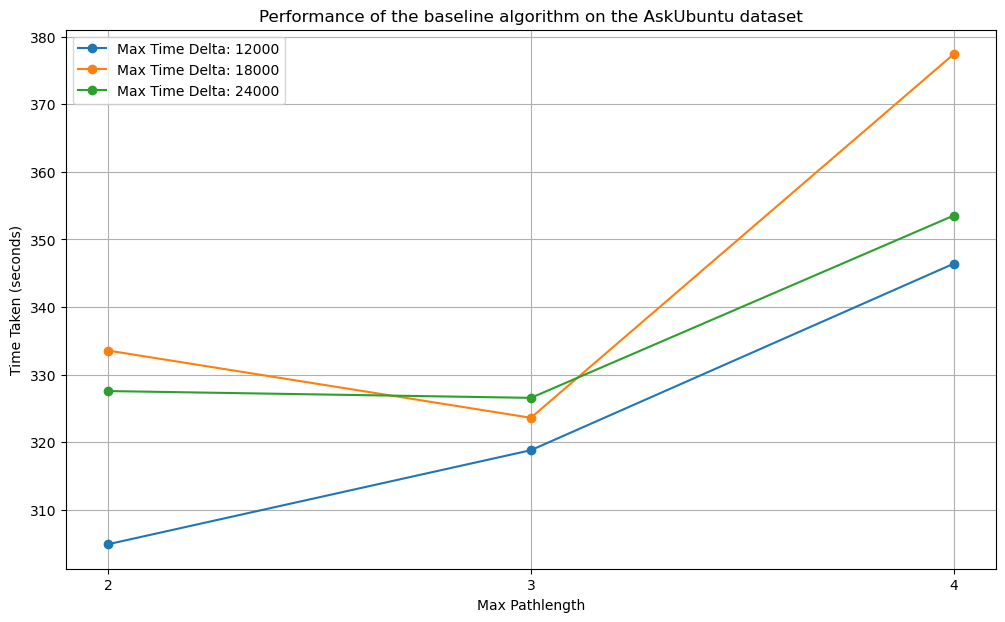

In [18]:
time_deltas = [12000, 18000, 24000]
max_orders = [2, 3, 4]
times = {
    12000: [304.8969, 318.8132, 346.4038],
    18000: [333.5554, 323.6074, 377.4106],
    24000: [327.5650, 326.5571, 353.5277]
}

# Plotting
plt.figure(figsize=(12, 7))

# Loop through each Max Time Delta to create a line for it
for delta in time_deltas:
    plt.plot(max_orders, times[delta], marker='o', label=f"Max Time Delta: {delta}")

# Customize plot
plt.title("Performance of the baseline algorithm on the AskUbuntu dataset")
plt.xlabel("Max Pathlength")
plt.ylabel("Time Taken (seconds)")
plt.xticks(max_orders)
plt.grid(True)
plt.legend()

# Display plot
plt.show()

In [37]:
combined_graph = []
for i in range(1,7):
    paths = temporal_paths.layers[i]
    for path in paths.edges:
        combined_graph.append(path)

In [38]:
print(len(combined_graph))

2468978
